# N(utrient)-P(hytoplankton)-Z(ooplankton)-D(etritus) Model

### A toy interactive model of ocean ecosystem dynamics

---
<center>
Riley X. Brady
</center>

<center>
riley.brady@colorado.edu
</center>

---

**References:**

1. J.L. Sarmiento and N. Gruber (2006). Ocean Biogeochemical Dynamics. Chapter 4: "Production."

2. A.M. Edwards (2001). Adding Detritus to a Nutrient–Phytoplankton–Zooplankton Model :A Dynamical-Systems Approach. J Plankton Res.

---

## Summary

We can create a reduced model of a complex lower-trophic ocean ecosystem with a few differential equations. Here, we choose to model four variables: an arbitrary nutrient concentration (generally thought of as a macronutrient such as nitrate), a phytoplankton concentration (maybe a diatom), a zooplankton concentration (with option to change the type of zooplankter), and a detritus concentration (waste products).

In reality, we are just modeling a finite reservoir of nitrate, and considering how it gets redistributed around the ecosystem, given a few initial conditions and parameter settings. In other words, we aren't explicitly modeling phytoplankton cell count or biomass, but rather tracking where the nitrate goes as it is incorporated into organic matter via photosynthesis, or consumed by zooplankton.

Differential equations (DE's) are complex things to deal with. In a model like this, we have four DE's interacting with one another, because the rate of change of the given population (nutrient, phytoplankton, zooplankton, or detritus) is dependent on the current state of the other three populations. Thus, it is a lot easier to discretize a model into time steps, and reduce our DE's into algebraic equations that may be solved in reference to the current state of the system.

Here, I use an explicit time-differencing scheme (forward Euler method) to model this simple ocean ecosystem.

---

## Differential Equations Contributing to the Model
The four raw DE's are as follows (where N is our nutrients, P is our phytoplankton, Z is our zooplankton, and D is our detritus):

$\frac{dN}{dt} = -V_{m}\left(\frac{N}{K_{N}+N}\right)f(I_{0})P~+~\alpha R_{m}\left(1-e^{-\lambda P}\right)Z~+~\epsilon P~+~gZ~+~\phi D$

$\frac{dP}{dt} = V_{m}\left(\frac{N}{K_{N} + N}\right)f(I_{0})P~-~R_{m}\left(1 - e^{-\lambda P}\right)Z~-~\epsilon P~-~rP$

$\frac{dZ}{dt} = \beta R_{m}\left(1-e^{-\lambda P}\right)Z~-~gZ$

$\frac{dD}{dt} = rP~+~(1 - \alpha - \beta)R_{m}\left(1 - e^{-\lambda P}\right)Z~-~\phi D$

---

### Terms

#### Bulk Terms

If you look closely at each DE, you note that these are simply source (+) minus sink (-) equations. This simple model only has a few nitrogen exchange processes:

$V_{m}\left(\frac{N}{K_{N} + N}\right)f(I_{0})P$ : Phytoplankton grazing term. How much inorganic nitrogen are they taking up?

$R_{m}\left(1-e^{-\lambda P}\right)Z$ : Zooplankton grazing term. How much nitrogen are they taking up after consuming phytoplankton and releasing some as waste? The $\beta$ coefficient represents the proportion taken up into zooplankton organic matter; the $\alpha$ coefficient is that which is dissolved back into nutrients (perhaps from urine); and (1-$\alpha$-$\beta$) is that which is excreted as fecal pellets (to the detritus compartment).

$\epsilon P$ : How much nitrogen is being returned to the pool from phytoplankton death?

$gZ$ : How much nitrogen is being returned to the pool from zooplankton death?

$rP$ : How much nitrogen is being respired by phytoplankton into detritus?

#### Phytoplankton Terms

$V_{m}$ : Maximum growth rate of an individual plankter (div per day). This value is dependent on temperature, via a lab-derived equation for diatoms: $V_{m} = a\cdot b^{T}$, with $a=0.6d^{-1}$, $b=1.066$, and $c=1(degC)^{-1}$.

$K_{N}$ : Half-saturation constant for nitrogen uptake ($\mu molNl^{-1}$). This is the nitrogen concentration at which the phytoplankton growth rate is at half its maximum value.

$f_{0}$ : Light intensity (0 to 1 weighting function). This is a simple parameterization of a more complex hyperbolic term that uses a similar term to $K_{N}$.

$\epsilon$ : Phytoplankton death rate (cells per day).

$r$ : Respiration rate (per day).

#### Zooplankton Terms

$R_{m}$ : Maximum grazing rate of zooplankton on phytoplankton (cells per day).

$\lambda$ : Grazing constant ($\mu molNl^{-1}$).

$\beta$ : Proportion of assimilated nitrogen by zooplankton. In other words, when they graze upon a phytoplankter, how efficient are they at taking up the nitrogen? (dimensionless)

$\alpha$ : Proportion of nitrogen taken up by zooplankton that returns to the environment as dissolved nutrients (urine?).

$g$ : Zooplankton death rate (critters per day).

#### Detritus Terms
$\phi$ : The remineralization rate of detritus back into dissolved nutrients (per day).

---
### Fixed Values/Initial Conditions

|                 Parameter                |   Symbol   |   Default Value   |
|:----------------------------------------:|:----------:|:-----------------:|
| Ambient Temperature                      |      T     |      15 degC      |
| Half-saturation constant for $N$ uptake  |   $K_{N}$  |  1$\mu$mol per L  |
| Maximum Grazing Rate                     |   R$_{m}$  |     1 $d^{-1}$    |
| Zooplankton Death Rate                   |      g     |    0.2$d^{-1}$    |
| Zooplankton Grazing Constant             |  $\lambda$ | 0.2$\mu$mol per L |
| Phytoplankton Death Rate                 | $\epsilon$ |    0.1$d^{-1}$    |
| Proportional Light Intensity             |   f$_{0}$  |        0.25       |
| Zooplankton Dissolved Excretion Fraction |  $\alpha$  |        0.3        |
| Zooplankton Assimilation Efficiency      |   $\beta$  |        0.6        |
| Phytoplankton Respiration Rate           |      r     |        0.15       |
| Detritus Remineralization Rate           |   $\phi$   |    0.4 $d^{-1}$   |

In [2]:
#### Code rewritten by Wing-Ho Ko, 2025-01-27

### Import modules

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import ipywidgets as widgets

In [5]:
%matplotlib ipympl

### Create interactive

### Step 2: interactive plots

In [6]:
#### Set up parameters for the initial plot

# Here we set up the default parameters/coefficients.
DT = 1 # Time Step (in days)
NUM_STEPS = 150 # Number of time steps to be computed and plotted

# Temperature-Dependent Growth Rate
a = 0.6
b = 1.066
c = 1
T = 15
Vm = a * b**(c*T) # Maximum growth rate (per day)

# Other parameters
Kn = 1    # Half-saturation constant for nitrogen uptake (umolN per l)
Rm = 1    # Maximum grazing rate (per day)
g = 0.2  # Zooplankton death rate (per day)
lambda_Z = 0.2  # Grazing constant (umolN per l)
epsilon = 0.1  # Phyto death rate (per day)
f = 0.25 # Light intensity (assumed constant)

# Detritus-related stuff.
alpha = 0.3 # Fraction of zoo. uptake that goes immediately to dissolved nutrients.
beta = 0.6  # Assimilation efficiency of zooplankton.
r = 0.15 # Respiration rate.
phi = 0.4 # Remineralization rate of detritus.

cmap = ["#bebada", "#8dd3c7", "#fb8072", "#e5d8bd"]
labels = ["Nutrients", "Phytoplankton", "Zooplankton", "Detritus"]

# Set Initial Conditions (umol per L)
N_0 = 4
P_0 = 2.5
Z_0 = 1.5
D_0 = 0

sum_0 = N_0 + P_0 + Z_0 + D_0

# Initialize Arrays
N = np.zeros(NUM_STEPS, dtype="float")
P = np.zeros(NUM_STEPS, dtype="float")
Z = np.zeros(NUM_STEPS, dtype="float")
D = np.zeros(NUM_STEPS, dtype="float")
t_array = np.arange(0, NUM_STEPS)

# Insert Initial Values
N[0] = N_0
P[0] = P_0
Z[0] = Z_0
D[0] = D_0

#### Solve for the results in the initial plot

# Here we use the Euler forward method to solve for t+1 and reference t.
for idx in np.arange(1, NUM_STEPS, 1):
    t = idx - 1

    # Common terms for simpler code
    gamma_N   = N[t] / (Kn + N[t])
    zoo_graze = Rm * (1 - np.exp(-lambda_Z * P[t])) * Z[t]

    # Equation calculations
    N[idx] = DT * (-Vm*gamma_N*f*P[t] + alpha*zoo_graze + epsilon*P[t] + g*Z[t] + phi*D[t]) + N[t]
    P[idx] = DT * (Vm*gamma_N*f*P[t] - zoo_graze - epsilon*P[t] - r*P[t]) + P[t]
    Z[idx] = DT * (beta*zoo_graze - g*Z[t]) + Z[t]
    D[idx] = DT * (r*P[t] + (1-alpha-beta)*zoo_graze - phi*D[t]) + D[t]

N_bottom = np.zeros(NUM_STEPS, dtype="float")
P_bottom = N
Z_bottom = N + P
D_bottom = N + P + Z

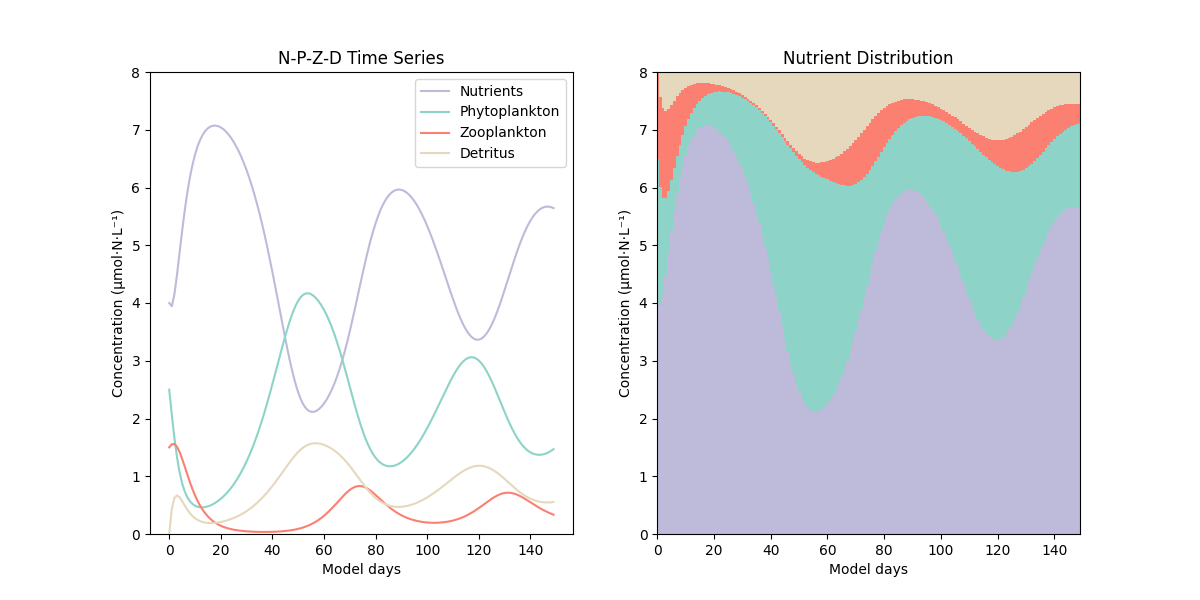

In [7]:
#### Setup plot elements

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

line_N, = ax1.plot(t_array, N, c=cmap[0], label=labels[0])
line_P, = ax1.plot(t_array, P, c=cmap[1], label=labels[1])
line_Z, = ax1.plot(t_array, Z, c=cmap[2], label=labels[2])
line_D, = ax1.plot(t_array, D, c=cmap[3], label=labels[3])

ax1.set_ylim(0, sum_0)

ax1.set_xlabel("Model days")
ax1.set_ylabel("Concentration (μmol·N·L⁻¹)")
ax1.set_title("N-P-Z-D Time Series")

ax1.legend()

ax2.bar(t_array, N, color=cmap[0], label=labels[0], bottom = N_bottom, width=1)
ax2.bar(t_array, P, color=cmap[1], label=labels[1], bottom = P_bottom, width=1)
ax2.bar(t_array, Z, color=cmap[2], label=labels[2], bottom = Z_bottom, width=1)
ax2.bar(t_array, D, color=cmap[3], label=labels[3], bottom = D_bottom, width=1)

ax2.set_xlim(t_array[0], t_array[-1])
ax2.set_ylim(0, sum_0)

ax2.set_xlabel("Model days")
ax2.set_ylabel("Concentration (μmol·N·L⁻¹)")
ax2.set_title("Nutrient Distribution")


#### Setup constants

# parameters
NUM_STEPS = 150
Kn = 1
dt = 1
lambda_Z = 0.2

# Detritus-Related Parameters
alpha = 0.3
beta = 0.6
r = 0.15
phi = 0.4

# Parameters for Maximum Grazing Rate
a  = 0.6
b  = 1.066


#### Setup function to update plot

def update_plot(nut, phyto, zoo, det, temperature, z_death, p_death, light, zooSpecies):

    print(zooSpecies)
    
    # parameters
    g = z_death

    epsilon = p_death
    f = light
    T = temperature

    #Zooplankton Species (impacts grazing rate)
    if (zooSpecies == "Cladoceran"):
        Rm = 1.6
    elif (zooSpecies == "Copepod"):
        Rm = 1.8
    elif (zooSpecies == "Mysid"):
        Rm = 1
    else:
        Rm = 2

    # calculate Maximum Grazing Rate
    Vm = a * b**T
    
    N = np.zeros(NUM_STEPS, dtype="float")
    P = np.zeros(NUM_STEPS, dtype="float")
    Z = np.zeros(NUM_STEPS, dtype="float")
    D = np.zeros(NUM_STEPS, dtype="float")
    t_array = np.arange(0, NUM_STEPS) * dt
    
    # Initial Conditions with modifications allowed
    # Insert Initial Values for model
    N[0] = nut
    P[0] = phyto
    Z[0] = zoo
    D[0] = det

    sum_0 = nut + phyto + zoo + det

    # compute time series
    for idx in range(1, NUM_STEPS, 1):
        
        t = idx - 1;

        # Common terms
        gamma_N   = N[t] / (Kn + N[t])
        zoo_graze = Rm * (1 - np.exp(-lambda_Z * P[t])) * Z[t]

        # Equation calculations for model
        N[idx] = dt * (-Vm*gamma_N*f*P[t] + alpha*zoo_graze + epsilon*P[t] + g*Z[t] + phi*D[t]) + N[t];
        P[idx] = dt * (Vm*gamma_N*f*P[t] - zoo_graze - epsilon*P[t] - r*P[t]) + P[t];
        Z[idx] = dt * (beta*zoo_graze - g*Z[t]) + Z[t];
        D[idx] = dt * (r*P[t] + (1-alpha-beta)*zoo_graze - phi*D[t]) + D[t];    

    N_bottom = np.zeros(NUM_STEPS, dtype="float")
    P_bottom = N
    Z_bottom = N + P
    D_bottom = N + P + Z

    #print(N)
    #print(P)
    #print(Z)
    #print(D)

    # modify plot objects
    line_N.set_data(t_array, N)
    line_P.set_data(t_array, P)
    line_Z.set_data(t_array, Z)
    line_D.set_data(t_array, D)

    ax1.set_ylim(0, sum_0)
    
    ax2.cla()
    ax2.bar(t_array, N, color=cmap[0], label=labels[0], bottom = N_bottom, width=1)
    ax2.bar(t_array, P, color=cmap[1], label=labels[1], bottom = P_bottom, width=1)
    ax2.bar(t_array, Z, color=cmap[2], label=labels[2], bottom = Z_bottom, width=1)
    ax2.bar(t_array, D, color=cmap[3], label=labels[3], bottom = D_bottom, width=1)

    ax2.set_xlim(t_array[0], t_array[-1])
    ax2.set_ylim(0, sum_0)
    
    ax2.set_xlabel("Model days")
    ax2.set_ylabel("Concentration (μmol·N·L⁻¹)")
    ax2.set_title("Nutrient Distribution")

#### Setup interactive output

# Nutrient Initial Conditions
nut_slider = widgets.FloatSlider(min = 0, max = 10, step = 0.5, value = 4)

# Phytoplankton Initial Conditions
phyto_slider = widgets.FloatSlider(min = 0, max = 10, step = 0.5, value = 2.5)

# Zooplankton Initial Conditions
zoo_slider = widgets.FloatSlider(min = 0, max = 10, step = 0.5, value = 1.5)

# Detritus Initial Conditions
det_slider = widgets.FloatSlider(min = 0, max = 10, step = 0.5, value = 0)

# Ambient Temperature
temp_slider = widgets.IntSlider(min = 0, max = 25, step = 1, value = 15)

# Phytoplankton Death Rate
pdeath_slider = widgets.FloatSlider(min = 0, max = 0.5, step = 0.05, value = 0.1)

# Zooplankton Death Rate
zdeath_slider = widgets.FloatSlider(min = 0, max = 0.5, step = 0.05, value = 0.2)

# Light Intensity
light_slider = widgets.FloatSlider(min = 0, max = 1, step = 0.05, value = 0.25)

species_toggle = widgets.ToggleButtons(
    options=["Cladoceran", "Copepod", "Mysid", "Rotifer"],
    description='Species:', value = "Mysid"
)

widgets.interactive_output(update_plot, {
    "nut": nut_slider, "phyto": phyto_slider, "zoo": zoo_slider, "det": det_slider,
    "temperature": temp_slider, "p_death": pdeath_slider, "z_death": zdeath_slider,
    "light": light_slider, "zooSpecies": species_toggle
})

controls = widgets.VBox([
    widgets.HBox([
        widgets.VBox([
            widgets.HBox([widgets.Label(value="Initial Nutrient Concentration"), nut_slider]),
            widgets.HBox([widgets.Label(value="Initial Phytoplankton Concentration"), phyto_slider]),
            widgets.HBox([widgets.Label(value="Initial Zooplankton Concentration"), zoo_slider]),
            widgets.HBox([widgets.Label(value="Initial Detritus Concentration"), det_slider])
        ], layout=widgets.Layout(display='flex', align_items="flex-end")), 
        widgets.VBox([
            widgets.HBox([widgets.Label(value="Water Temperature (°C)"), temp_slider]),
            widgets.HBox([widgets.Label(value="Phytoplankton Natural Death Rate (per day)"), pdeath_slider]), 
            widgets.HBox([widgets.Label(value="Zooplankton Natural Death Rate (per day)"), zdeath_slider]),
            widgets.HBox([widgets.Label(value="Proportional Light Intensity"), light_slider])
        ], layout=widgets.Layout(display='flex', align_items="flex-end"))
    ], max_width=1200), species_toggle
])

display(controls)
plt.show()